# Lab 9 - Long Short Term Networks

## Q1
Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current
year. Prices are in nominal dollars. The task is to predict the price of natural gas using LSTM model
for the dataset
https://datahub.io/core/natural-gas#resource-daily or
https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices
Given the price of last ten 10 days, corresponds to sequence_length, the LSTM model must predict
the price for the 11th day

0 th iteration :  tensor(0.2124, device='cuda:0', grad_fn=<MseLossBackward0>)
50 th iteration :  tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)
100 th iteration :  tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
150 th iteration :  tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)
200 th iteration :  tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)
250 th iteration :  tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
300 th iteration :  tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
350 th iteration :  tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
400 th iteration :  tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
450 th iteration :  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
500 th iteration :  tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)
550 th iteration :  tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)
600 th iteration :  tensor(0.0004, device='

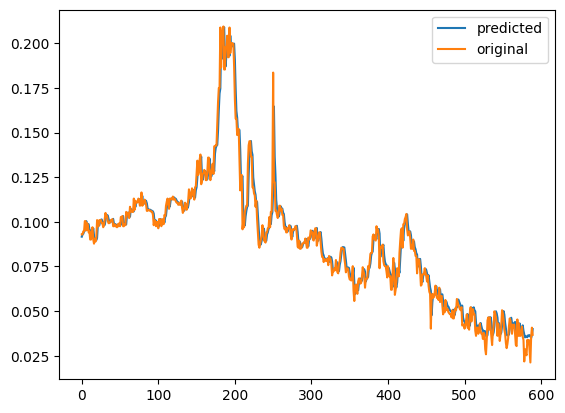

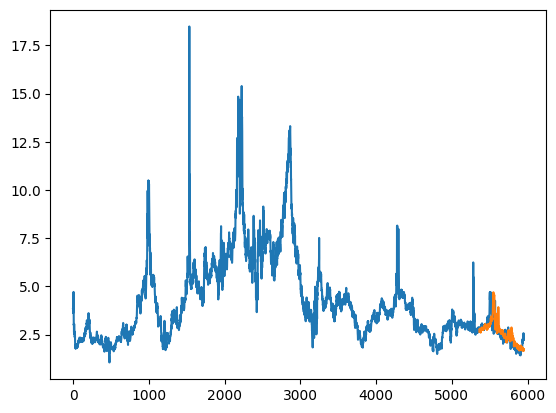

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

df = pd.read_csv("../data/natural_gas_prices/daily.csv").dropna()
y = df['Price'].values
x = np.arange(1, len(y), 1)
minm, maxm = y.min(), y.max()
y = (y - minm) / (maxm - minm)
seq_len = 10
X, Y = [], []
for i in range(5900):
    X.append(y[i:i + seq_len])
    Y.append(y[i + seq_len])
X, Y = np.array(X), np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)

class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x, self.y, self.len = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.len

train_loader = DataLoader(NGTimeSeries(x_train, y_train), shuffle=True, batch_size=256)

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.fc1(torch.relu(self.lstm(x)[0][:, -1, :]))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1500

for i in range(epochs):
    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch.to(device).view(-1, seq_len, 1)).reshape(-1)
        loss = criterion(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if i % 50 == 0:
        print(i, "th iteration : ", loss)

test_loader = DataLoader(NGTimeSeries(x_test, y_test), batch_size=len(x_test))
test_x, test_y = next(iter(test_loader))
test_pred = model(test_x.to(device).view(-1, 10, 1)).view(-1).cpu().detach().numpy()
test_y = test_y.cpu().detach().numpy()
plt.plot(test_pred, label='predicted')
plt.plot(test_y, label='original')
plt.legend()
plt.show()

y = y * (maxm - minm) + minm
y_pred = test_pred * (maxm - minm) + minm
plt.plot(y)
plt.plot(range(len(y) - len(y_pred), len(y)), y_pred)
plt.show()

## Q2
The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
names stored in the format {language: [names ...]} i.e. each language contains a list of
names. Train a LSTM on a few thousand surnames from 18 languages of origin, and
predict which language a name is from based on the spelling.

Epoch  1 | Loss: 1.8170 | Val Acc: 60.85%
Epoch  2 | Loss: 0.9961 | Val Acc: 68.29%
Epoch  3 | Loss: 0.6812 | Val Acc: 69.91%
Epoch  4 | Loss: 0.5012 | Val Acc: 73.28%
Epoch  5 | Loss: 0.4062 | Val Acc: 74.45%
Epoch  6 | Loss: 0.3343 | Val Acc: 76.21%
Epoch  7 | Loss: 0.2797 | Val Acc: 75.77%
Epoch  8 | Loss: 0.2512 | Val Acc: 76.46%
Epoch  9 | Loss: 0.2270 | Val Acc: 78.80%
Epoch 10 | Loss: 0.2096 | Val Acc: 75.82%
Epoch 11 | Loss: 0.1826 | Val Acc: 77.83%
Epoch 12 | Loss: 0.1785 | Val Acc: 78.98%
Epoch 13 | Loss: 0.1760 | Val Acc: 78.83%
Epoch 14 | Loss: 0.1651 | Val Acc: 78.51%
Epoch 15 | Loss: 0.1621 | Val Acc: 79.23%
Epoch 16 | Loss: 0.1483 | Val Acc: 80.67%
Epoch 17 | Loss: 0.1367 | Val Acc: 79.70%
Epoch 18 | Loss: 0.1305 | Val Acc: 80.32%
Epoch 19 | Loss: 0.1295 | Val Acc: 80.97%
Epoch 20 | Loss: 0.1337 | Val Acc: 80.95%
Epoch 21 | Loss: 0.1359 | Val Acc: 81.52%
Epoch 22 | Loss: 0.1296 | Val Acc: 81.12%
Epoch 23 | Loss: 0.1122 | Val Acc: 81.84%
Epoch 24 | Loss: 0.1055 | Val Acc:

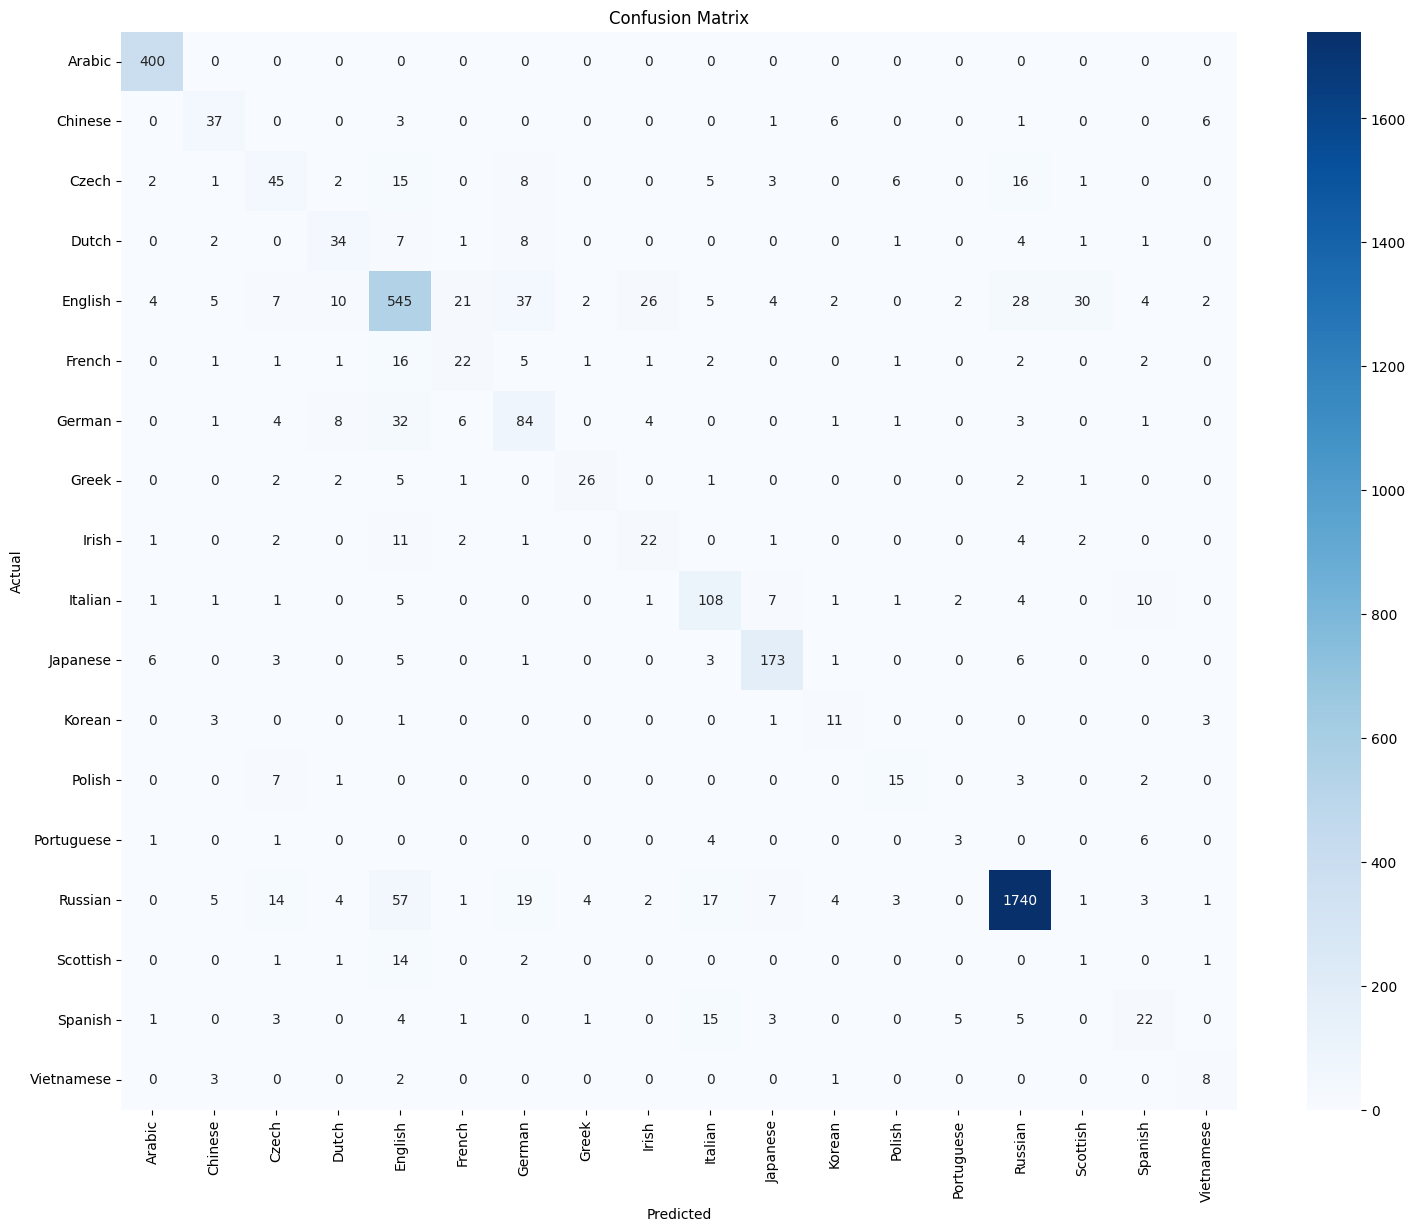

In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

torch.manual_seed(42)
np.random.seed(42)

DATA_DIR = os.path.join("..", "data", "names", "names")

def load_data():
    languages, names = [], []
    for filename in os.listdir(DATA_DIR):
        if filename.endswith(".txt"):
            lang = filename.split(".")[0]
            with open(os.path.join(DATA_DIR, filename), 'r', encoding='utf-8') as f:
                lang_names = f.read().strip().split('\n')
                languages.extend([lang] * len(lang_names))
                names.extend(lang_names)
    return names, languages

names, languages = load_data()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(languages)
num_classes = len(label_encoder.classes_)

all_chars = set(''.join(names))
char_to_idx = {'<PAD>': 0, '<UNK>': 1}
for i, char in enumerate(sorted(all_chars), 2):
    char_to_idx[char] = i
vocab_size = len(char_to_idx)

class NameDataset(Dataset):
    def __init__(self, names, labels):
        self.names = names
        self.labels = labels
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        name = self.names[idx]
        indices = [char_to_idx.get(c, 1) for c in name]
        return torch.tensor(indices, dtype=torch.long), self.labels[idx]

X_train, X_test, y_train, y_test = train_test_split(
    names, labels, test_size=0.2, stratify=labels, random_state=42
)

class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

def collate_fn(batch):
    names, labels = zip(*batch)
    lengths = torch.tensor([len(name) for name in names])
    padded = nn.utils.rnn.pad_sequence(names, batch_first=True, padding_value=0)
    return padded, lengths, torch.tensor(labels, dtype=torch.long)

train_dataset = NameDataset(X_train, y_train)
test_dataset = NameDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset, batch_size=128, sampler=sampler, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=256, collate_fn=collate_fn
)

class NameClassifierLSTM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 128, padding_idx=0)
        self.lstm = nn.LSTM(128, 256, bidirectional=True, num_layers=2, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, (hidden, _) = self.lstm(packed)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(hidden)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NameClassifierLSTM(vocab_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

def train_model(epochs=50):
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for inputs, lengths, labels in train_loader:
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)
        
        acc = evaluate_model()
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), 'best_model_lstm_cuda.pth')
            
        print(f"Epoch {epoch+1:2d} | Loss: {avg_loss:.4f} | Val Acc: {acc:.2f}%")

def evaluate_model():
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, lengths, labels in test_loader:
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            outputs = model(inputs, lengths)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

train_model()

def plot_confusion_matrix():
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, lengths, labels in test_loader:
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            outputs = model(inputs, lengths)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(18, 14))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def analyze_errors():
    model.eval()
    errors = []
    
    with torch.no_grad():
        for i in range(len(test_dataset)):
            name = X_test[i]
            label = y_test[i]
            tensor_name, length = test_dataset[i][0], len(test_dataset[i][0])
            tensor_name, length = tensor_name.unsqueeze(0).to(device), torch.tensor([length]).to(device)
            output = model(tensor_name, length)
            _, pred = torch.max(output, 1)
            
            if pred.item() != label:
                errors.append((
                    name,
                    label_encoder.inverse_transform([label])[0],
                    label_encoder.inverse_transform([pred.item()])[0]
                ))

plot_confusion_matrix()
analyze_errors()

def predict_language(name):
    model.eval()
    with torch.no_grad():
        indices = [char_to_idx.get(c, 1) for c in name]
        tensor = torch.tensor(indices).unsqueeze(0).to(device)
        length = torch.tensor([len(indices)]).to(device)
        output = model(tensor, length)
        _, pred = torch.max(output, 1)
        return label_encoder.inverse_transform([pred.item()])[0]

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

text = "hello world, this is a character-level RNN example."
seq_length = 10
batch_size = 32
embedding_dim = 64
hidden_size = 128
num_layers = 2
dropout = 0.2
learning_rate = 0.001
num_epochs = 500
temperature = 0.5

chars = sorted(list(set(text)))
char_to_idx = {c:i for i, c in enumerate(chars)}
idx_to_char = {i:c for i, c in enumerate(chars)}
vocab_size = len(chars)

encoded = [char_to_idx[c] for c in text]

class CharDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data[idx+self.seq_length], dtype=torch.long)
        return x, y

dataset = CharDataset(encoded, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class CharLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, 
                         num_layers=num_layers, 
                         dropout=dropout,
                         batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

model = CharLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch+1) % 50 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

def generate_text(model, seed, length=100):
    model.eval()
    device = next(model.parameters()).device
    generated = list(seed)
    
    h = torch.zeros(num_layers, 1, hidden_size).to(device)
    c = torch.zeros(num_layers, 1, hidden_size).to(device)
    
    for _ in range(length):
        input_seq = generated[-seq_length:]
        x = torch.tensor([char_to_idx[c] for c in input_seq], 
                        dtype=torch.long).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output, (h, c) = model(x, (h, c))
            
        probs = F.softmax(output / temperature, dim=1).cpu()
        next_char = torch.multinomial(probs, num_samples=1).item()
        
        generated.append(idx_to_char[next_char])
    
    return ''.join(generated)

seed = "hello wor"
generated = generate_text(model, seed, length=100)
print(f"\nGenerated text:\n{generated}")

Epoch 50/500 | Loss: 0.4999
Epoch 100/500 | Loss: 0.0692
Epoch 150/500 | Loss: 0.0186
Epoch 200/500 | Loss: 0.0117
Epoch 250/500 | Loss: 0.0070
Epoch 300/500 | Loss: 0.0047
Epoch 350/500 | Loss: 0.0036
Epoch 400/500 | Loss: 0.0027
Epoch 450/500 | Loss: 0.0024
Epoch 500/500 | Loss: 0.0021

Generated text:
hello worddddde              iisccccccc aahcccctttctllllllleeeeeeeeeeee  .....xxxaaaa aaaeccecccp--llllleleee
